In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from matplotlib.patches import FancyArrowPatch

class MutualExcitationNetwork:
    def __init__(self, w1=0.4, w2=0.4, I=-10):
        """
        Initialize the 2D network with mutual excitation.
        
        Parameters:
        - w1: Synaptic strength from x to y
        - w2: Synaptic strength from y to x
        - I: External input to both neurons
        """
        self.w1 = w1          # Synaptic strength from x to y
        self.w2 = w2          # Synaptic strength from y to x
        self.I = I            # External input
        
    def activation_function(self, s):
        """Sigmoid activation function: f(s) = 50 * σ(s) = 50 / (1 + e^(-s))"""
        return 50 / (1 + np.exp(-s))
    
    def activation_derivative(self, s):
        """Derivative of sigmoid function: σ'(s) = σ(s)(1 - σ(s))"""
        sigma = 1 / (1 + np.exp(-s))
        return 50 * sigma * (1 - sigma)
    
    def derivatives(self, state):
        """Calculate dx/dt and dy/dt for the network"""
        x, y = state
        
        # Calculate total inputs
        input_to_x = self.w2 * y + self.I
        input_to_y = self.w1 * x + self.I
        
        # Calculate derivatives
        dx_dt = -x + self.activation_function(input_to_x)
        dy_dt = -y + self.activation_function(input_to_y)
        
        return np.array([dx_dt, dy_dt])
    
    def simulate(self, initial_state, t_max, dt=0.1):
        """Simulate the network dynamics"""
        steps = int(t_max / dt)
        t = np.linspace(0, t_max, steps)
        state = np.zeros((steps, 2))
        state[0] = initial_state
        
        for i in range(1, steps):
            derivatives = self.derivatives(state[i-1])
            state[i] = state[i-1] + derivatives * dt
            
        return t, state
    
    def simulate_multiple(self, initial_states, t_max, dt=0.1):
        """Simulate the network dynamics for multiple initial conditions"""
        results = []
        
        for init_state in initial_states:
            t, state = self.simulate(init_state, t_max, dt)
            results.append((t, state))
            
        return results
    
    def plot_dynamics(self, initial_states, t_max, dt=0.1):
        """Plot the time evolution of x(t) and y(t) for different initial conditions"""
        results = self.simulate_multiple(initial_states, t_max, dt)
        
        # Create two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
        
        for i, (t, state) in enumerate(results):
            x = state[:, 0]
            y = state[:, 1]
            
            label = f"Initial: ({initial_states[i][0]}, {initial_states[i][1]})"
            ax1.plot(t, x, label=label)
            ax2.plot(t, y, label=label)
        
        ax1.set_ylabel('Neuron x firing rate')
        ax1.set_title('Time evolution of neuron x')
        ax1.grid(True)
        ax1.legend()
        
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Neuron y firing rate')
        ax2.set_title('Time evolution of neuron y')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def plot_state_space(self, initial_states, t_max, dt=0.1, show_nullclines=False, 
                       show_fixed_points=False, quiver=False):
        """Plot trajectories in state space (x vs y)"""
        results = self.simulate_multiple(initial_states, t_max, dt)
        
        plt.figure(figsize=(10, 8))
        
        # Plot trajectories
        for i, (t, state) in enumerate(results):
            x = state[:, 0]
            y = state[:, 1]
            
            # Plot trajectory
            plt.plot(x, y, label=f"Initial: ({initial_states[i][0]}, {initial_states[i][1]})")
            
            # Add arrow to show direction
            arrow_idx = min(len(x) - 10, max(10, len(x) // 5))
            plt.arrow(x[arrow_idx], y[arrow_idx], 
                      x[arrow_idx+1] - x[arrow_idx], 
                      y[arrow_idx+1] - y[arrow_idx],
                      head_width=1, head_length=1, fc='k', ec='k')
        
        # Show nullclines if requested
        if show_nullclines:
            self.add_nullclines_to_plot()
        
        # Show fixed points if requested
        if show_fixed_points:
            fixed_points = self.find_fixed_points()
            if fixed_points:
                fps = np.array(fixed_points)
                plt.scatter(fps[:, 0], fps[:, 1], color='red', s=100, 
                           zorder=5, label='Fixed Points')
        
        # Add vector field (quiver plot) if requested
        if quiver:
            self.add_vector_field_to_plot()
        
        plt.xlabel('Neuron x firing rate')
        plt.ylabel('Neuron y firing rate')
        plt.title('State Space: x vs y')
        plt.grid(True)
        plt.legend()
        plt.show()
    
    def x_nullcline(self, y_range):
        """Calculate x-nullcline points where dx/dt = 0"""
        y_values = np.linspace(y_range[0], y_range[1], 1000)
        
        # For x-nullcline: x = f(w2*y + I)
        x_values = self.activation_function(self.w2 * y_values + self.I)
        
        return y_values, x_values
    
    def y_nullcline(self, x_range):
        """Calculate y-nullcline points where dy/dt = 0"""
        x_values = np.linspace(x_range[0], x_range[1], 1000)
        
        # For y-nullcline: y = f(w1*x + I)
        y_values = self.activation_function(self.w1 * x_values + self.I)
        
        return x_values, y_values
    
    def add_nullclines_to_plot(self, x_range=(0, 50), y_range=(0, 50)):
        """Add nullclines to the current plot"""
        # Get nullclines
        y_vals, x_vals = self.x_nullcline(y_range)
        x_vals_y, y_vals_y = self.y_nullcline(x_range)
        
        # Plot nullclines
        plt.plot(x_vals, y_vals, 'r--', label='x-nullcline: dx/dt = 0')
        plt.plot(x_vals_y, y_vals_y, 'b--', label='y-nullcline: dy/dt = 0')
    
    def add_vector_field_to_plot(self, density=20, scale=10):
        """Add vector field to the current plot"""
        # Create grid
        x = np.linspace(0, 50, density)
        y = np.linspace(0, 50, density)
        X, Y = np.meshgrid(x, y)
        
        # Calculate derivatives at each point
        U = np.zeros_like(X)
        V = np.zeros_like(Y)
        
        for i in range(density):
            for j in range(density):
                derivatives = self.derivatives([X[i, j], Y[i, j]])
                U[i, j] = derivatives[0]
                V[i, j] = derivatives[1]
        
        # Normalize
        magnitude = np.sqrt(U**2 + V**2)
        U = U / (magnitude + 1e-10) * scale  # Avoid division by zero
        V = V / (magnitude + 1e-10) * scale
        
        plt.quiver(X, Y, U, V, alpha=0.3, color='gray')
    
    def plot_nullclines(self, x_range=(0, 50), y_range=(0, 50)):
        """Plot nullclines of the system"""
        plt.figure(figsize=(10, 8))
        
        self.add_nullclines_to_plot(x_range, y_range)
        
        plt.xlabel('Neuron x firing rate')
        plt.ylabel('Neuron y firing rate')
        plt.title('Nullclines of the 2D Network')
        plt.grid(True)
        plt.legend()
        plt.show()
    
    def find_fixed_points(self):
        """Find fixed points of the system by solving nullcline equations"""
        def system_eqs(state):
            return self.derivatives(state)
        # Grid search method to find all fixed points
        # Use a moderate grid size
        grid_size = 20
        x_values = np.linspace(-50, 100, grid_size)
        y_values = np.linspace(-50, 100, grid_size)
        
        # Create grid for search
        X, Y = np.meshgrid(x_values, y_values)
        grid_points = np.vstack([X.ravel(), Y.ravel()]).T
        
        # Calculate derivatives norm at each grid point
        derivative_norms = np.zeros(len(grid_points))
        for i, point in enumerate(grid_points):
            derivative_norms[i] = np.linalg.norm(self.derivatives(point))
        
        # Select points with smallest derivatives as initial guesses
        threshold = np.percentile(derivative_norms, 10)  # Bottom 10% of derivative norms
        candidate_indices = np.where(derivative_norms < threshold)[0]
        
        # Select a subset of these points, well distributed
        initial_guesses = []
        min_distance = 5.0  # Minimum distance between initial guesses
        
        for idx in candidate_indices:
            point = grid_points[idx]
            if not initial_guesses or all(np.linalg.norm(point - np.array(g)) > min_distance for g in initial_guesses):
                initial_guesses.append(point)
        
        # Always include standard guesses
        standard_guesses = [
            [0, 0],      # Low-low
            [50, 50],    # High-high
            [0, 50],     # Low-high
            [50, 0],     # High-low
            [25, 25]     # Middle
        ]
        
        for guess in standard_guesses:
            if not any(np.linalg.norm(np.array(guess) - np.array(g)) < min_distance/2 for g in initial_guesses):
                initial_guesses.append(guess)
        
        # Refine potential fixed points using fsolve
        fixed_points = []
        for guess in initial_guesses:
            solution = fsolve(system_eqs, guess)
            
            # Check if solution is valid and not already found
            if (0 <= solution[0] <= 50 and 0 <= solution[1] <= 50 and  # Within bounds
            np.all(np.abs(system_eqs(solution)) < 1e-10) and       # Actually a fixed point
            all(np.linalg.norm(solution - fp) > 1e-6 for fp in fixed_points)):  # Not a duplicate
                fixed_points.append(solution)
        
        return fixed_points
    
    def analyze_fixed_points(self):
        """Analyze stability of fixed points using the Jacobian matrix"""
        fixed_points = self.find_fixed_points()
        analysis = []
        
        for fp in fixed_points:
            x, y = fp
            
            # Calculate elements of Jacobian matrix at fixed point
            input_x = self.w2 * y + self.I
            input_y = self.w1 * x + self.I
            
            df_dx = -1
            df_dy = self.w2 * self.activation_derivative(input_x)
            dg_dx = self.w1 * self.activation_derivative(input_y)
            dg_dy = -1
            
            # Create Jacobian matrix
            J = np.array([[df_dx, df_dy],
                          [dg_dx, dg_dy]])
            
            # Calculate eigenvalues
            eigenvalues = np.linalg.eigvals(J)
            
            # Calculate trace and determinant
            trace = np.trace(J)
            det = np.linalg.det(J)
            
            # Determine stability
            stability = "Stable" if np.all(np.real(eigenvalues) < 0) else "Unstable"
            
            # Classification based on trace and determinant
            if det < 0:
                classification = "Saddle point"
            elif trace**2 - 4*det < 0:
                classification = "Spiral"
            else:
                classification = "Node"
            
            analysis.append({
                'fixed_point': fp,
                'eigenvalues': eigenvalues,
                'trace': trace,
                'determinant': det,
                'stability': stability,
                'classification': classification
            })
        
        return analysis
    
    def compute_bifurcation_diagram(self, I_range=(-20, -10), I_steps=100):
        """Compute bifurcation diagram as a function of external input I"""
        I_values = np.linspace(I_range[0], I_range[1], I_steps)
        num_fixed_points = []
        fixed_points_x = []
        fixed_points_y = []
        
        original_I = self.I  # Store original I
        
        for I in I_values:
            self.I = I
            fps = self.find_fixed_points()
            num_fixed_points.append(len(fps))
            
            # Store x and y coordinates for plotting
            if fps:
                fps_array = np.array(fps)
                fixed_points_x.append(fps_array[:, 0])
                fixed_points_y.append(fps_array[:, 1])
            else:
                fixed_points_x.append([])
                fixed_points_y.append([])
        
        self.I = original_I  # Restore original I
        
        return I_values, num_fixed_points, fixed_points_x, fixed_points_y
    
    def plot_bifurcation_diagram(self, I_range=(-20, -10), I_steps=100):
        """Plot bifurcation diagram as a function of external input I"""
        I_values, num_fp, fp_x, fp_y = self.compute_bifurcation_diagram(I_range, I_steps)
        
        # Plot number of fixed points
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        plt.plot(I_values, num_fp)
        plt.xlabel('External Input (I)')
        plt.ylabel('Number of Fixed Points')
        plt.title('Bifurcation Diagram: Number of Fixed Points vs External Input')
        plt.grid(True)
        
        # Plot fixed points
        plt.subplot(2, 1, 2)
        colors = ['r', 'g', 'b', 'c', 'm']
        
        # Collect all x coordinates for each fixed point "branch"
        branches = {}
        
        for i, I in enumerate(I_values):
            for j, x in enumerate(fp_x[i]):
                if j not in branches:
                    branches[j] = {'I': [], 'x': []}
                branches[j]['I'].append(I)
                branches[j]['x'].append(x)
        
        # Plot each branch
        for j, branch in branches.items():
            plt.plot(branch['I'], branch['x'], f'{colors[j % len(colors)]}-', 
                     label=f'Branch {j+1}')
        
        plt.xlabel('External Input (I)')
        plt.ylabel('Fixed Point x-coordinate')
        plt.title('Bifurcation Diagram: Fixed Points vs Externa Input')
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout()
        plt.show()


--- Problem 2.1: Plot the dynamics ---


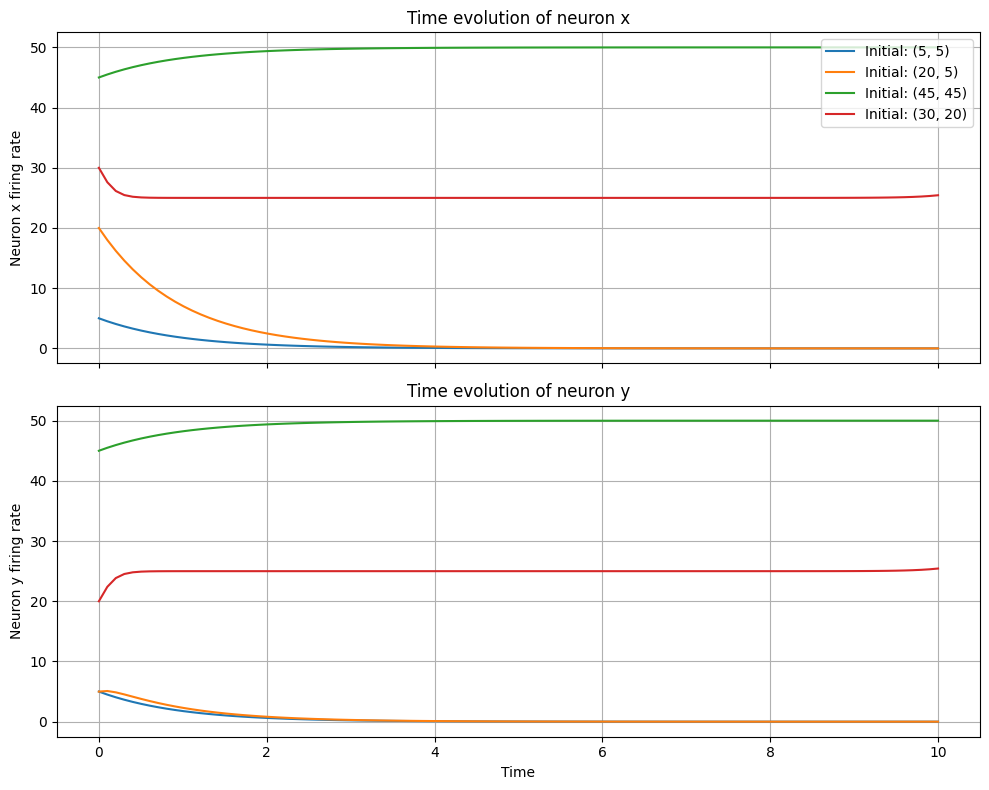

Plotted the time evolution of neuron firing rates x(t) and y(t) for different initial conditions.


In [20]:
import numpy as np
import matplotlib.pyplot as plt


"""
2.1 Plot the dynamics - Plot the evolution in time of the firing rate of 
the two neurons x(t) and y(t), for different initial conditions
"""
print("\n--- Problem 2.1: Plot the dynamics ---")

# Create network with default parameters: w1=w2=0.4, I=-10
network = MutualExcitationNetwork()

# Define different initial conditions
initial_states = [
    [5, 5],    # Low-low initial state
    [20, 5],   # Middle-low initial state
    [45, 45],  # High-high initial state
    [30, 20]   # Mixed initial state
]

# Plot dynamics
network.plot_dynamics(initial_states, t_max=10)

print("Plotted the time evolution of neuron firing rates x(t) and y(t) for different initial conditions.")





--- Problem 2.2: Plot state space ---


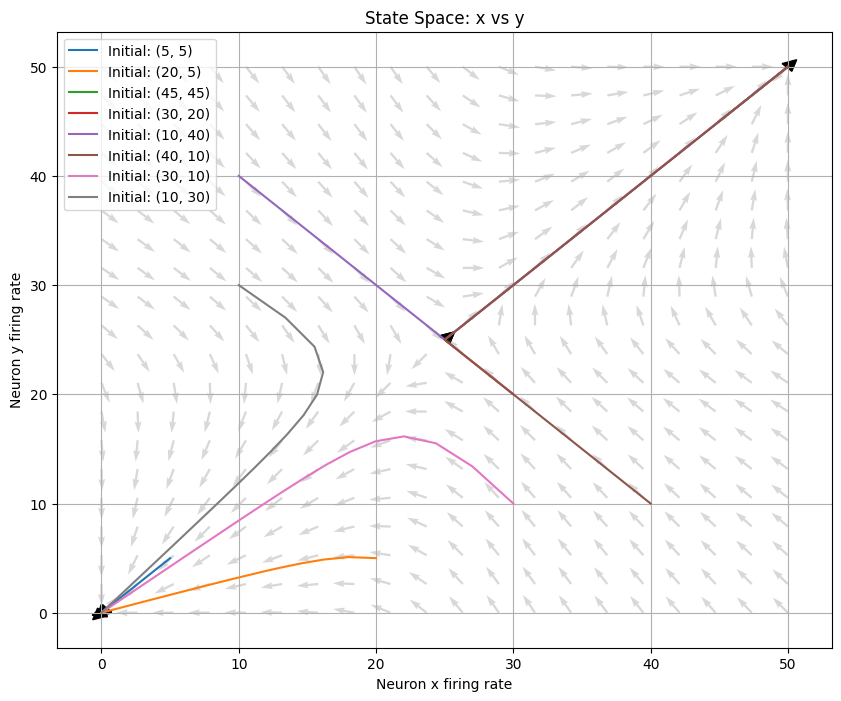

Plotted the state space trajectories for different initial conditions.


In [21]:

"""
2.2 State space - Plot the trajectories in the state space, for different initial conditions
"""
print("\n--- Problem 2.2: Plot state space ---")

# Create network
network = MutualExcitationNetwork()

# Define initial conditions for state space trajectories
initial_states = [
    [5, 5],    # Low-low initial state
    [20, 5],   # Middle-low initial state
    [45, 45],  # High-high initial state
    [30, 20],  # Mixed initial state
    [10, 40],  # Low-high initial state
    [40, 10],   # High-low initial state
    [30, 10],
    [10, 30],


]

# Plot state space without nullclines
network.plot_state_space(initial_states, t_max=20, quiver=True)

print("Plotted the state space trajectories for different initial conditions.")


--- Problem 2.3: Compute and plot nullclines ---


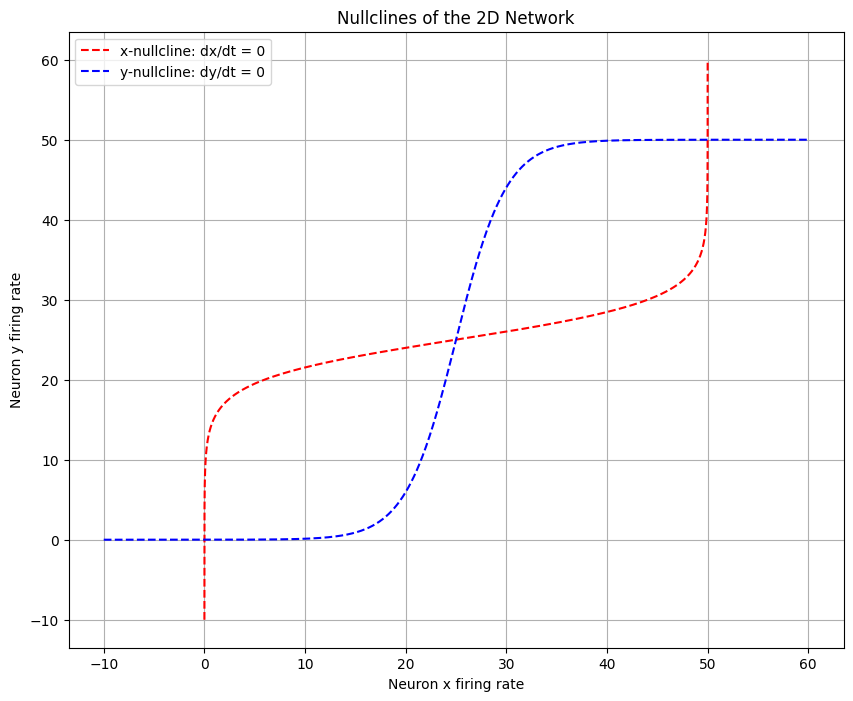

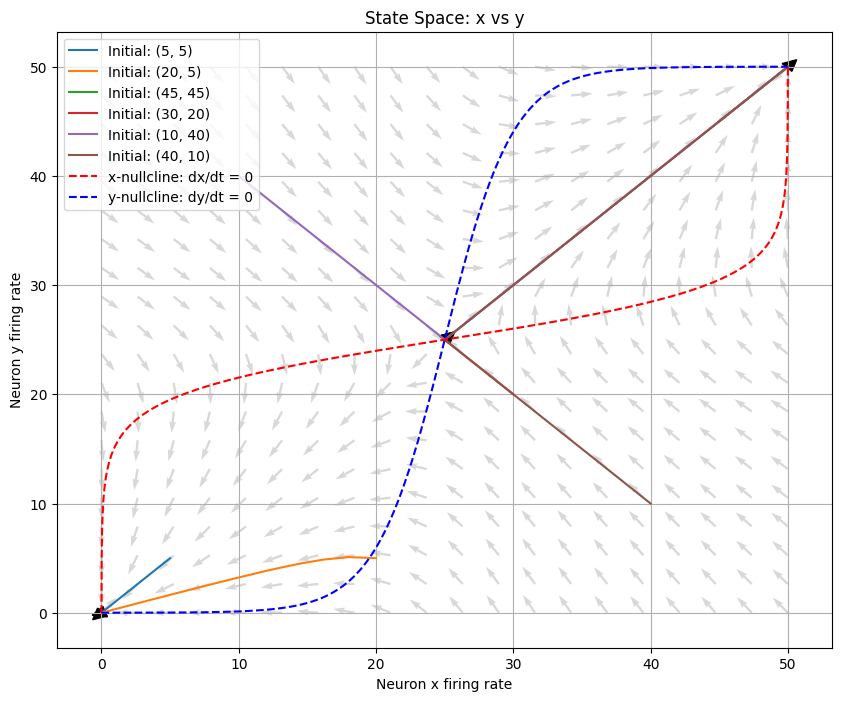

Computed and plotted the nullclines of the system.
x-nullcline equation: x = f(w2*y + I) = f(0.4*y - 10)
y-nullcline equation: y = f(w1*x + I) = f(0.4*x - 10)
The nullclines cross at the fixed points of the system.


In [22]:



"""
2.3 Nullclines - Compute the nullclines of the system and plot them
"""
print("\n--- Problem 2.3: Compute and plot nullclines ---")

# Create network
network = MutualExcitationNetwork()

# Plot nullclines
network.plot_nullclines(x_range=(-10, 60), y_range=(-10, 60))

# Plot state space with nullclines for better visualization
initial_states = [
    [5, 5],    # Low-low initial state
    [20, 5],   # Middle-low initial state
    [45, 45],  # High-high initial state
    [30, 20],  # Mixed initial state
    [10, 40],  # Low-high initial state
    [40, 10]   # High-low initial state
]

network.plot_state_space(initial_states, t_max=20, 
                            show_nullclines=True, quiver=True)

print("Computed and plotted the nullclines of the system.")
print("x-nullcline equation: x = f(w2*y + I) = f(0.4*y - 10)")
print("y-nullcline equation: y = f(w1*x + I) = f(0.4*x - 10)")
print("The nullclines cross at the fixed points of the system.")



--- Problem 2.4: Find fixed points and infer stability ---
Fixed points (where nullclines cross):
Fixed point 1: x = 0.002272, y = 0.002272
Fixed point 2: x = 49.997728, y = 49.997728
Fixed point 3: x = 25.000000, y = 25.000000


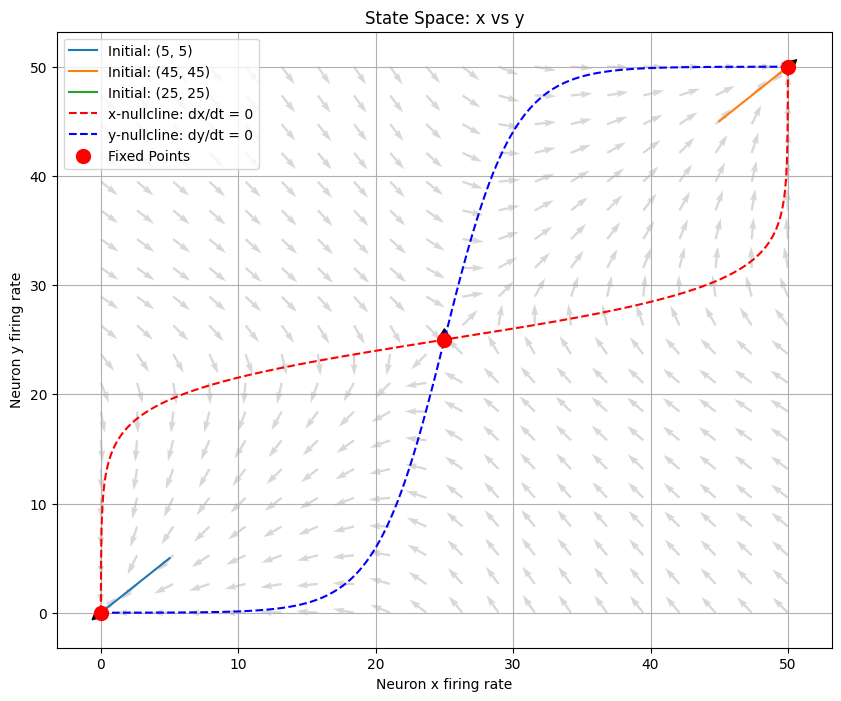


Qualitative stability analysis:
Based on the trajectories in state space:
- If trajectories converge to the fixed point, it's stable.
- If trajectories diverge from the fixed point, it's unstable.


In [16]:


"""
2.4 Fixed points - Find the fixed points and infer their stability
"""
print("\n--- Problem 2.4: Find fixed points and infer stability ---")

# Create network
network = MutualExcitationNetwork()

# Find fixed points
fixed_points = network.find_fixed_points()

print("Fixed points (where nullclines cross):")
for i, fp in enumerate(fixed_points):
    print(f"Fixed point {i+1}: x = {fp[0]:.6f}, y = {fp[1]:.6f}")

# Plot state space with nullclines and fixed points
initial_states = [
    [5, 5],    # Low-low initial state
    [45, 45],  # High-high initial state
    [25, 25]   # Middle initial state
]

network.plot_state_space(initial_states, t_max=20, 
                            show_nullclines=True, 
                            show_fixed_points=True, quiver=True)

print("\nQualitative stability analysis:")
print("Based on the trajectories in state space:")
print("- If trajectories converge to the fixed point, it's stable.")
print("- If trajectories diverge from the fixed point, it's unstable.")



In [23]:


"""
2.5 [Extra point] Study the stability of the fixed points analytically
"""
print("\n--- Problem 2.5: Analytical stability analysis ---")

# Create network
network = MutualExcitationNetwork()

# Analyze fixed points
analysis = network.analyze_fixed_points()

print("Analytical stability analysis using Jacobian matrix:")
for i, result in enumerate(analysis):
    fp = result['fixed_point']
    print(f"\nFixed point {i+1}: x = {fp[0]:.6f}, y = {fp[1]:.6f}")
    print(f"Eigenvalues: {result['eigenvalues']}")
    print(f"Trace: {result['trace']:.6f}")
    print(f"Determinant: {result['determinant']:.6f}")
    print(f"Stability: {result['stability']}")
    print(f"Classification: {result['classification']}")
    
    # Explanation
    if result['determinant'] < 0:
        print("This is a saddle point (unstable) because the determinant is negative.")
    elif result['trace'] < 0 and result['determinant'] > 0:
        if result['trace']**2 - 4*result['determinant'] < 0:
            print("This is a stable spiral because trace < 0 and trace²-4*det < 0.")
        else:
            print("This is a stable node because trace < 0 and trace²-4*det > 0.")
    else:
        if result['trace']**2 - 4*result['determinant'] < 0:
            print("This is an unstable spiral because trace > 0 and trace²-4*det < 0.")
        else:
            print("This is an unstable node because trace > 0 and trace²-4*det > 0.")



--- Problem 2.5: Analytical stability analysis ---
Analytical stability analysis using Jacobian matrix:

Fixed point 1: x = 0.002272, y = 0.002272
Eigenvalues: [-0.99909126 -1.00090874]
Trace: -2.000000
Determinant: 0.999999
Stability: Stable
Classification: Node
This is a stable node because trace < 0 and trace²-4*det > 0.

Fixed point 2: x = 25.000000, y = 25.000000
Eigenvalues: [ 4. -6.]
Trace: -2.000000
Determinant: -24.000000
Stability: Unstable
Classification: Saddle point
This is a saddle point (unstable) because the determinant is negative.

Fixed point 3: x = 49.997728, y = 49.997728
Eigenvalues: [-0.99909126 -1.00090874]
Trace: -2.000000
Determinant: 0.999999
Stability: Stable
Classification: Node
This is a stable node because trace < 0 and trace²-4*det > 0.



--- Problem 2.6: Bifurcation diagram ---


/var/folders/mx/zr8t6k3s0xz2w8s2hl4llfj40000gn/T/ipykernel_15753/913645149.py:252: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  solution = fsolve(system_eqs, guess)
/var/folders/mx/zr8t6k3s0xz2w8s2hl4llfj40000gn/T/ipykernel_15753/913645149.py:252: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  solution = fsolve(system_eqs, guess)
/var/folders/mx/zr8t6k3s0xz2w8s2hl4llfj40000gn/T/ipykernel_15753/913645149.py:22: RuntimeWarning: overflow encountered in exp
  return 50 / (1 + np.exp(-s))


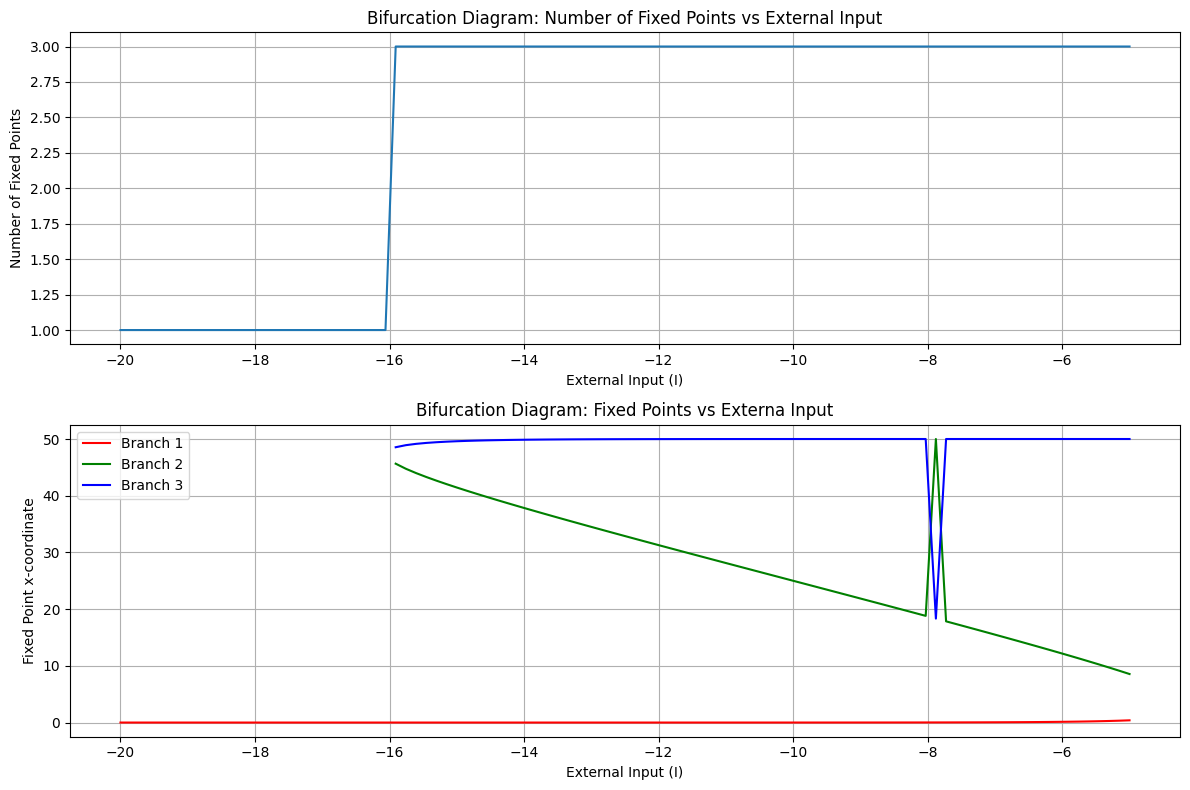

Number of fixed points at different input values:
I = -20: 1 fixed point(s)
  Fixed points:
  x = 0.000000, y = 0.000000
I = -17: 1 fixed point(s)
  Fixed points:
  x = 0.000002, y = 0.000002
I = -14: 3 fixed point(s)
  Fixed points:
  x = 0.000042, y = 0.000042
  x = 37.837305, y = 37.837305
  x = 49.869775, y = 49.869775
I = -11: 3 fixed point(s)
  Fixed points:
  x = 0.000835, y = 0.000835
  x = 28.129124, y = 28.129124
  x = 49.993815, y = 49.993815
I = -8: 3 fixed point(s)
  Fixed points:
  x = 0.016881, y = 0.016881
  x = 18.715593, y = 18.715593
  x = 49.999693, y = 49.999693

Analysis of bifurcation diagram:
- The system exhibits different regimes depending on the input current I.
- There are regions with 1 fixed point and regions with 3 fixed points.
- The transition between these regimes occurs at specific bifurcation points.
- When I is very negative, there is only one stable fixed point (low firing rate).
- As I increases, two additional fixed points emerge (bistability reg

In [34]:
"""
2.6 Bifurcation diagram - Show how the number of solutions changes with input current
"""
print("\n--- Problem 2.6: Bifurcation diagram ---")

# Create network
network = MutualExcitationNetwork()

# Plot bifurcation diagram
network.plot_bifurcation_diagram(I_range=(-20, -5), I_steps=100)

# Check specific values
test_I_values = list(range(-20, -5, 3))

print("Number of fixed points at different input values:")
original_I = network.I

for I in test_I_values:
    network.I = I
    fps = network.find_fixed_points()
    print(f"I = {I}: {len(fps)} fixed point(s)")
    
    if fps:
        print("  Fixed points:")
        for fp in fps:
            print(f"  x = {fp[0]:.6f}, y = {fp[1]:.6f}")

# Reset to original value
network.I = original_I

print("\nAnalysis of bifurcation diagram:")
print("- The system exhibits different regimes depending on the input current I.")
print("- There are regions with 1 fixed point and regions with 3 fixed points.")
print("- The transition between these regimes occurs at specific bifurcation points.")
print("- When I is very negative, there is only one stable fixed point (low firing rate).")
print("- As I increases, two additional fixed points emerge (bistability regime).")
print("- Further increasing I may lead back to a single fixed point (high firing rate).")


[-20, -17, -14, -11, -8]